# Heritability Analysis

As an application of the variance component model, this note demonstrates the workflow for heritability analysis in genetics, using a sample data set `SNP_29C` with **212** individuals and **253,141** SNPs. Person IDs and phenotype names are masked for privacy. `SNP_29C.bed`, `SNP_29C.bim`, and `SNP_29C.fam` is a set of Plink files in binary format. `SNP_29C_traits.txt` contains 2 phenotypes of the 212 individuals.

In [4]:
;ls "SNP_29C*.*"

SNP_29C.bed
SNP_29C.bim
SNP_29C.fam
SNP_29C.jld
SNP_29C_results.jld
SNP_29Ctraitdata.csv


Machine information:

In [2]:
versioninfo()

Julia Version 0.6.0
Commit 903644385b (2017-06-19 13:05 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Prescott)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, broadwell)


## Read in binary SNP data

We will use the [`SnpArrays.jl`](https://github.com/OpenMendel/SnpArrays.jl) package to read in binary SNP data and compute the empirical kinship matrix. Issue 
```julia
Pkg.clone("https://github.com/OpenMendel/SnpArrays.jl.git")
```
within `Julia` to install the `SnpArrays` package.

In [3]:
using SnpArrays

In [4]:
# read in genotype data from Plink binary file (~50 secs on my laptop)
@time SNP_29C = SnpArray("SNP_29C")

  0.551275 seconds (218.60 k allocations: 24.407 MiB, 1.30% gc time)


212×253141 SnpArrays.SnpArray{2}:
 (true, true)  (true, true)   …  (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)   …  (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 (true, true)  (true, true)      (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 (true, true)  (false, true)  …  (false, false)  (true, true)  
 (true, true)  (true, true)      (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 ⋮                            ⋱                  ⋮             
 (true, true)  (true, true)   …  (true, true)    (false, false)
 (true

## Summary statistics of SNP data

In [5]:
people, snps = size(SNP_29C)

(212, 253141)

In [6]:
# summary statistics (~50 secs on my laptop)
@time maf, _, missings_by_snp, = summarize(SNP_29C);

  0.395411 seconds (19.62 k allocations: 4.798 MiB)


In [7]:
# 5 number summary and average MAF (minor allele frequencies)
quantile(maf, [0.0 .25 .5 .75 1.0]), mean(maf)

([0.00235849 0.0117925 … 0.228774 0.5], 0.13381461170905357)


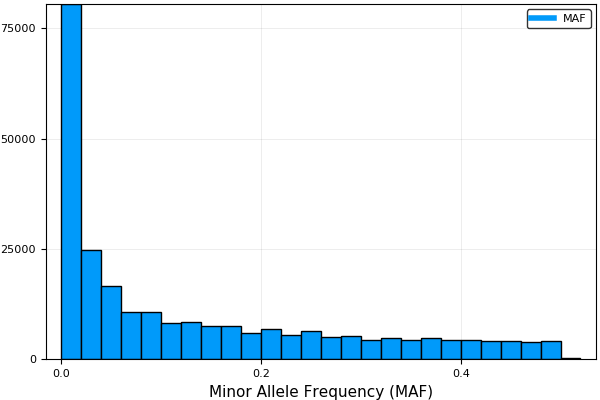

In [8]:
# Pkg.add("Plots")
# Pkg.add("PyPlot")
using Plots
pyplot()

histogram(maf, xlab = "Minor Allele Frequency (MAF)", label = "MAF")

In [13]:
# proportion of missing genotypes
sum(missings_by_snp) / length(SNP_29C)

0.0

In [14]:
# proportion of rare SNPs with maf < 0.05
countnz(maf .< 0.05) / length(maf)

0.4558724189285813

## Empirical Kinship Matrix

In this example we estimate the empirical kinships based on all SNPs by Method of Moments Estimation(MOM). 

Note: Both the GRM and the MoM methods are fairly quick to calculate and provide good estimates for the kinship coefficients, given reasonably dense genome-wide data. When using the GRM method, very rare SNPs should not be used since they become overweighted. In general, one can think of the GRM method centering and scaling each genotype, while the MoM method uses the raw genotypes and then centers and scales the final result.

### Kinship via Genetic Relationship Matrix (GRM)

Under the GRM formulation, the estimate of the global kinship coefficient of individuals $i$ and $j$ is
$$ \hat\Phi_{ij}^* = \frac{1}{2S} \sum_{k=1}^S \frac{(x_{ik} -2p_k)(x_{jk} - 2p_k)}{2 p_k (1-p_k)}$$
where $k$ ranges over the selected $S$ SNPs, $p_k$ is the minor allele frequency of SNP $k$, and $x_{ik}$ is the number of minor alleles in individual $i$s genotype at SNP $k$.

### Kinship via Method of Moments (MOM)
Using the Method of Moments (MoM) formula, the estimate of the global kinship coefficient of individuals $i$ and $j$ is
$$ \hat \Phi_{ij} = \frac{e_{ij} - \sum_{k=1}^S \left[p_k^2 + (1-p_k)^2 \right]}{S - \sum_{k=1}^S\left[p_k^2 + (1-p_k)^2\right]}, $$
where
$$ e_{ij}  =  \frac{1}{4} \sum_{k=1}^S \left[ x_{ik}x_{jk} + (2-x_{ik})(2-x_{jk}) \right] $$
is the observed fraction of alleles identical by state (IBS) between $i$ and $j$.

In [22]:
@time ΦGRM = grm(SNP_29C; method = :MoM)

  5.057744 seconds (112.69 M allocations: 2.176 GiB, 12.85% gc time)


212×212 Array{Float64,2}:
  0.500079     -0.00537615   0.0147603   …  -0.0199991   -0.00591813
 -0.00537615    0.504623    -0.0241786      -0.0672657   -0.0237929 
  0.0147603    -0.0241786    0.499996       -0.0595738   -0.00660602
  0.235605     -0.0252938    0.261401       -0.0530596   -0.0239701 
  0.1033        0.237763     0.109533       -0.0759373   -0.0214999 
 -0.010181      0.00334758   0.00408759  …  -0.0329857    0.0210035 
 -0.0231571     0.00529661  -0.0125469      -0.0515588   -0.0051677 
 -0.0205827    -0.00904491  -0.0204681      -0.0472855   -0.00435473
 -0.00704377    0.0142809    0.00213856     -0.0599802    0.00786057
 -0.0243036    -0.0142562   -0.0214374      -0.0470041   -0.0197385 
 -0.0237408    -0.00131133   0.00149236  …  -0.0557904    0.00596366
 -0.00814857    0.00747494   0.00419181     -0.0439398    0.0132595 
 -0.0305468     0.00544253  -0.00842998     -0.0337152    0.0170533 
  ⋮                                      ⋱   ⋮                      
 -0.0005

## Using Existing Kinship Matrix

We calculated the theoretical kinships based on the pedigree structure.

In the case where the kinship matrix has already been calculated, we can read in an existing GRM file.
It is important to be mindful of what type of format your kinship matrix is in, as the command to read in different file types may change. In this example we use Comma-Separated-Values (CSV) file, ΦGRM_ped.csv.

Note: All missing genotypes in this file must be imputed before any further analysis

In [27]:
ΦGRM_ped = readcsv("kinship_ped29c.csv", Float64; header = false)

212×212 Array{Float64,2}:
 0.5    0.0   0.0    0.25  0.125  0.0    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.5   0.0    0.0   0.25   0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.5    0.25  0.125  0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.25   0.0   0.25   0.5   0.25   0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.125  0.25  0.125  0.25  0.5    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.5    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.12

In [18]:
eigvals(ΦGRM_ped)

212-element Array{Float64,1}:
 0.0553906
 0.0568537
 0.0590686
 0.0636213
 0.0649598
 0.0724847
 0.0739113
 0.0746095
 0.0752486
 0.0753409
 0.0757652
 0.0759949
 0.077326 
 ⋮        
 1.53908  
 1.56543  
 1.63932  
 1.67539  
 1.78062  
 1.95725  
 2.15074  
 2.18934  
 2.68311  
 2.72034  
 2.86783  
 3.25065  

## Phenotypes

Read in the phenotype data and compute descriptive statistics.

In [9]:
# Pkg.add("DataFrames")
using DataFrames

SNP_29C_trait = readtable(
    "SNP_29Ctraitdata.csv"; header = false,
    separator = ',',
    names = [:FID; :IID; :Trait1; :Trait2],  
    eltypes = [Int; Int; Float64; Float64]
    )

size(SNP_29C_trait)

(212, 4)

In [5]:
SNP_29C_trait

,FID,IID,Trait1,Trait2
1,1,16,30.20564,9.2421
2,1,8228,35.82143,15.27458
3,1,17008,36.05298,19.50496
4,1,9218,38.96351,18.98575
5,1,3226,33.73911,21.10412
6,2,29,34.88835,19.01142
7,2,2294,37.70105,19.16556
8,2,3416,45.13171,19.84088
9,2,17893,35.15599,14.14228
10,2,6952,42.45136,19.92713


### Univariate Phenotype Analysis

For both of the phenotypic traits, first check summary statistics and distribution-patterns to ensure the proper statistical methods for our analysis. 

Note: With a small sample size, it is important to look for any potential outliers or influential observations as they may influence your results greatly. Additionally, it is important to consider the small sample size 
when looking at histograms. 

In [20]:
describe(SNP_29C_trait[:, 3:end])

Trait1
Summary Stats:
Mean:           37.860176
Minimum:        29.240310
1st Quartile:   34.694473
Median:         37.653830
3rd Quartile:   41.589585
Maximum:        47.861930
Length:         212
Type:           Float64
Number Missing: 0
% Missing:      0.000000

Trait2
Summary Stats:
Mean:           18.471994
Minimum:        9.242100
1st Quartile:   15.769725
Median:         18.534045
3rd Quartile:   20.840625
Maximum:        27.555420
Length:         212
Type:           Float64
Number Missing: 0
% Missing:      0.000000




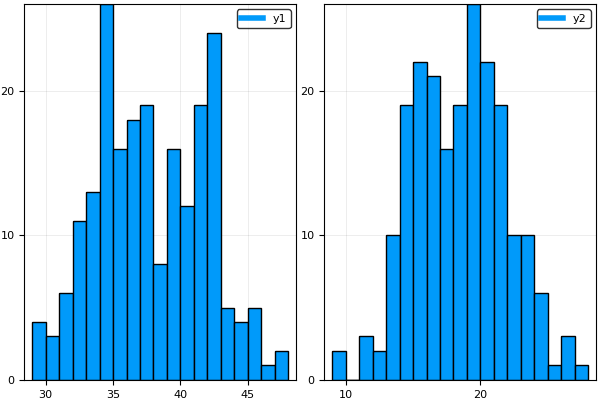

In [19]:
Y = convert(Matrix{Float64}, SNP_29C_trait[:, 3:end])
histogram(Y, layout = 2)

## Pre-processing data for heritability analysis

### Inverse-Normal Transformation

In this example, we consider a Rank-Based Inverse Normal Blom Transformations to remedy non-Normal Trait Values.

In [22]:
#Pkg.add("RCall")
using RCall

c = 3/8 # continuity correction c = 3/8
N = size(Y)[1]

Yt = zeros(Matrix{Float64}(size(Y)[1],size(Y)[2]))

tic()
for i in 1:size(Y)[2]
    for j in 1:size(Y)[1]
value = (tiedrank(Y[:,i]) - c)/(N - 2c + 1)
        
# Note that value, c and N are julia variables. @rput sends value, c and N to R with the same names
@rput N
@rput c
@rput value

# Fit a model in R
R" qz = qnorm(value)"

# If you want to retrieve a variable from R, look at this example

@rget qz
Yt[j, i] = qz[j]
    end
end
toc() 

elapsed time: 0.752669269 seconds


0.752669269


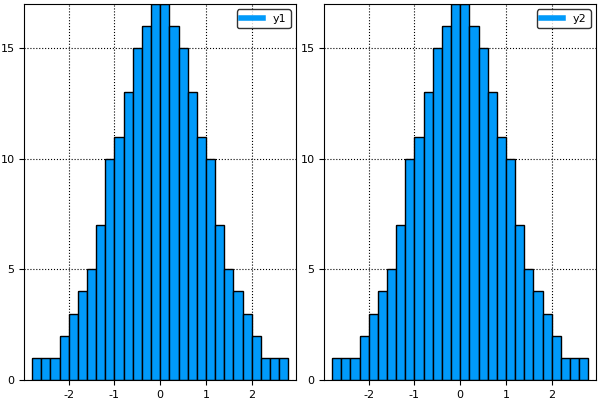

In [23]:
histogram(Yt, layout =2 )

### Center and Standardize Trait Values

Recall there are no any fixed effects in the model at this time. 

For some traits, both variance components may be estimated to zero, which can cause trouble for the heritability function to calculate standard errors (0 divided by 0). Thus, once the traits are standardized, estimates become reasonable and the problem disappears. Note for interpretation, this puts our phenotypes in units of standard deviation. 

In [20]:
Y = zscore(Y,1)

212×2 Array{Float64,2}:
 -1.89053    -2.73371 
 -0.503534   -0.94701 
 -0.446345    0.305944
  0.272504    0.152164
 -1.01783     0.779583
 -0.733988    0.159767
 -0.0393012   0.20542 
  1.79594     0.405437
 -0.667886   -1.28237 
  1.13394     0.430982
 -0.547702   -0.311834
  0.685187    1.54384 
 -0.740538   -0.474964
  ⋮                   
  0.541384    0.900445
  0.359587    1.88928 
  0.97092     1.20171 
 -0.377911   -0.411905
  1.25566    -0.377219
  0.501992    0.7204  
  1.1656     -0.750968
  2.47026     0.421262
  0.788596    1.96443 
  0.516206    0.370425
 -0.588395    1.02567 
  1.61354     2.26582 

To prepare variance component model fitting, we form an instance of `VarianceComponentVariate`. The two variance components are $(2\Phi, I)$.

In [58]:
# form data as VarianceComponentVariate
SNP_29Cdata = VarianceComponentVariate(Y, (2ΦGRM, eye(size(Y, 1))))
fieldnames(SNP_29Cdata)

3-element Array{Symbol,1}:
 :Y
 :X
 :V

Before fitting the variance component model, we pre-compute the eigen-decomposition of $2\Phi_{\text{GRM}}$, the rotated responses, and the constant part in log-likelihood, and store them as a `TwoVarCompVariateRotate` instance, which is re-used in various variane component estimation procedures.

In [59]:
@time SNP_29Cdata_rotated = TwoVarCompVariateRotate(SNP_29Cdata)
fieldnames(SNP_29Cdata_rotated)

  0.010855 seconds (34 allocations: 1.113 MiB)


5-element Array{Symbol,1}:
 :Yrot    
 :Xrot    
 :eigval  
 :eigvec  
 :logdetV2

In [84]:
# Same procedure for Theoretical Kinship Matrix
SNP_29Cdata_ped = VarianceComponentVariate(Y, (2ΦGRM_ped, eye(size(Y, 1))))
fieldnames(SNP_29Cdata_ped)
@time SNP_29Cdata_rotated_ped = TwoVarCompVariateRotate(SNP_29Cdata_ped)
fieldnames(SNP_29Cdata_rotated_ped)

  0.005519 seconds (33 allocations: 1.113 MiB)


5-element Array{Symbol,1}:
 :Yrot    
 :Xrot    
 :eigval  
 :eigvec  
 :logdetV2

## Save intermediate results

We don't want to re-compute SnpArray and empirical kinship matrices again and again for heritibility analysis.

In [24]:
Pkg.add("JLD")
using JLD
@save "SNP_29C.jld"
whos()

INFO: Updating cache of HDF5...
INFO: Installing Blosc v0.3.0
INFO: Installing HDF5 v0.8.5
INFO: Installing JLD v0.8.1
INFO: Installing LegacyStrings v0.2.2
INFO: Building Blosc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  130k  100  130k    0     0   165k      0 --:--:-- --:--:-- --:--:--  165k
INFO: Building Homebrew
INFO: Building HDF5
  likely near /Users/sarahji/.julia/v0.6/HDF5/deps/build.jl:39
  likely near /Users/sarahji/.julia/v0.6/HDF5/deps/build.jl:39
in can_use at /Users/sarahji/.julia/v0.6/Homebrew/src/bindeps_integration.jl
  likely near /Users/sarahji/.julia/v0.6/HDF5/deps/build.jl:39
in package_available at /Users/sarahji/.julia/v0.6/Homebrew/src/bindeps_integration.jl
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of JLD
INF

                          Base               Module
                       BinDeps  36902 KB     Module
                         Blosc  36760 KB     Module
                    ColorTypes  37023 KB     Module
                        Colors  37052 KB     Module
                        Compat  36768 KB     Module
                         Conda  36777 KB     Module
                          Core               Module
                    DataArrays  37015 KB     Module
                    DataFrames  37258 KB     Module
                DataStructures  36928 KB     Module
                        FileIO  36898 KB     Module
             FixedPointNumbers  37285 KB     Module
                          GZip  36771 KB     Module
                          HDF5  36994 KB     Module
                        IJulia  64110 KB     Module
                         Ipopt     29 KB     Module
                           JLD  36991 KB     Module
                          JSON  36914 KB     Module
            

To load workspace

In [1]:
using SnpArrays, JLD, DataFrames, VarianceComponentModels, Plots
pyplot()
@load "SNP_29C.jld"
whos()

                          Base  40725 KB     Module
                       BinDeps   6698 KB     Module
                         Blosc     59 KB     Module
                    ColorTypes   6779 KB     Module
                        Colors   6727 KB     Module
                        Compat   6403 KB     Module
                         Conda   6749 KB     Module
                          Core  16125 KB     Module
                    DataArrays   6717 KB     Module
                    DataFrames    650 KB     Module
                DataStructures    347 KB     Module
                        FileIO   7249 KB     Module
             FixedPointNumbers   6898 KB     Module
               FixedSizeArrays   6542 KB     Module
                          GZip   6321 KB     Module
                          HDF5   7012 KB     Module
                        IJulia   7661 KB     Module
                         Ipopt     32 KB     Module
                           JLD   7264 KB     Module
            

## Heritability of Single Traits

### Heritability via Empirical Kinship Matrix

We use Fisher scoring algorithm to fit variance component model for each single trait.

In [62]:
# heritability from single trait analysis
hST = zeros(2)
# standard errors of estimated heritability
hST_se = zeros(2)
# additive genetic effects
σ2a = zeros(2)
# enviromental effects
σ2e = zeros(2)
tic()
for j in 1:2
println(names(SNP_29C_trait)[j + 2])
traitj_data = TwoVarCompVariateRotate(SNP_29Cdata_rotated.Yrot[:, j], SNP_29Cdata_rotated.Xrot, SNP_29Cdata_rotated.eigval, SNP_29Cdata_rotated.eigvec, SNP_29Cdata_rotated.logdetV2)
    # initialize model parameters
traitj_model = VarianceComponentModel(traitj_data)
    # estimate variance components
_, _, _, Σcov, _, _ = mle_fs!(traitj_model, traitj_data; solver=:Ipopt, verbose=false)
σ2a[j] = traitj_model.Σ[1][1]
σ2e[j] = traitj_model.Σ[2][1]
@show σ2a[j], σ2e[j]
h, hse = heritability(traitj_model.Σ, Σcov)
hST[j] = h[1]
hST_se[j] = hse[1]
end
toc()

Trait1
(σ2a[j], σ2e[j]) = (0.18767414984760852, 0.815016168465228)
Trait2
(σ2a[j], σ2e[j]) = (0.5867851932928568, 0.4478568310705483)
elapsed time: 0.266841115 seconds


0.266841115

In [64]:
# heritability and standard errors
Heritability = [hST'; hST_se']

2×2 Array{Float64,2}:
 0.187171  0.567138
 0.181324  0.100037

### Heritability via Theoretical Kinship Matrix

In [87]:
# heritability from single trait analysis
hST_ped = zeros(2)
# standard errors of estimated heritability
hST_se_ped = zeros(2)
# additive genetic effects
σ2a_ped = zeros(2)
# enviromental effects
σ2e_ped = zeros(2)
tic()
for j in 1:2
println(names(SNP_29C_trait)[j + 2])
traitj_data = TwoVarCompVariateRotate(SNP_29Cdata_rotated_ped.Yrot[:, j], SNP_29Cdata_rotated_ped.Xrot, SNP_29Cdata_rotated_ped.eigval, SNP_29Cdata_rotated_ped.eigvec, SNP_29Cdata_rotated_ped.logdetV2)
    # initialize model parameters
traitj_model = VarianceComponentModel(traitj_data)
    # estimate variance components
_, _, _, Σcov, _, _ = mle_fs!(traitj_model, traitj_data; solver=:Ipopt, verbose=false)
σ2a_ped[j] = traitj_model.Σ[1][1]
σ2e_ped[j] = traitj_model.Σ[2][1]
@show σ2a_ped[j], σ2e_ped[j]
h, hse = heritability(traitj_model.Σ, Σcov)
hST_ped[j] = h[1]
hST_se_ped[j] = hse[1]
end
toc()

Trait1
(σ2a_ped[j], σ2e_ped[j]) = (0.24422977287189257, 0.7633399628059215)
Trait2
(σ2a_ped[j], σ2e_ped[j]) = (0.3155505795203914, 0.6890330688343218)
elapsed time: 0.059872006 seconds


0.059872006

In [88]:
# heritability and standard errors via theoretical kinship matrix
Heritability_ped = [hST_ped'; hST_se_ped']

2×2 Array{Float64,2}:
 0.242395  0.314111
 0.185323  0.171144

## Pairwise traits

Joint analysis of multiple traits is subject to intensive research recently. Following code snippet does joint analysis of all pairs of traits, a total of 78 bivariate variane component models.

### Joint Analysis via Empirical Kinship Matrix

In [65]:
# additive genetic effects (2x2 psd matrices) from bavariate trait analysis;
Σa = Array{Matrix{Float64}}(2, 2)
# environmental effects (2x2 psd matrices) from bavariate trait analysis;
Σe = Array{Matrix{Float64}}(2, 2)

tic()
for i in 1:2
    for j in (i+1):2
        println(names(SNP_29C_trait)[i + 2], names(SNP_29C_trait)[j + 2])
        # form data set for (trait1, trait2)
        traitij_data = TwoVarCompVariateRotate(SNP_29Cdata_rotated.Yrot[:, [i;j]], SNP_29Cdata_rotated.Xrot, 
            SNP_29Cdata_rotated.eigval, SNP_29Cdata_rotated.eigvec, SNP_29Cdata_rotated.logdetV2)
        # initialize model parameters
        traitij_model = VarianceComponentModel(traitij_data)
        # estimate variance components
        mle_fs!(traitij_model, traitij_data; solver=:Ipopt, verbose=false)
        Σa[i, j] = traitij_model.Σ[1]
        Σe[i, j] = traitij_model.Σ[2]
        @show Σa[i, j], Σe[i, j]
    end
end
toc()

Trait1Trait2
(Σa[i, j], Σe[i, j]) = ([0.195017 0.134769; 0.134769 0.463916], [0.808869 0.477019; 0.477019 0.532634])
elapsed time: 0.412166499 seconds


0.412166499

### Joint Analysis via Theoretical Kinship Matrix

In [89]:
# additive genetic effects (2x2 psd matrices) from bavariate trait analysis;
Σa_ped = Array{Matrix{Float64}}(2, 2)
# environmental effects (2x2 psd matrices) from bavariate trait analysis;
Σe_ped = Array{Matrix{Float64}}(2, 2)

tic()
for i in 1:2
    for j in (i+1):2
        println(names(SNP_29C_trait)[i + 2], names(SNP_29C_trait)[j + 2])
        # form data set for (trait1, trait2)
        traitij_data = TwoVarCompVariateRotate(SNP_29Cdata_rotated_ped.Yrot[:, [i;j]], SNP_29Cdata_rotated_ped.Xrot, 
            SNP_29Cdata_rotated_ped.eigval, SNP_29Cdata_rotated_ped.eigvec, SNP_29Cdata_rotated_ped.logdetV2)
        # initialize model parameters
        traitij_model = VarianceComponentModel(traitij_data)
        # estimate variance components
        mle_fs!(traitij_model, traitij_data; solver=:Ipopt, verbose=false)
        Σa_ped[i, j] = traitij_model.Σ[1]
        Σe_ped[i, j] = traitij_model.Σ[2]
        @show Σa_ped[i, j], Σe_ped[i, j]
    end
end
toc()

Trait1Trait2
(Σa_ped[i, j], Σe_ped[i, j]) = ([0.237948 0.101181; 0.101181 0.288777], [0.768533 0.502828; 0.502828 0.710809])
elapsed time: 0.059297611 seconds


0.059297611

## N-joint traits analysis

In some situations, such as studying the genetic covariance, we need to jointly analyze all N > 2 traits. 
We first try the **Fisher scoring algorithm**. (Demo: If SNP_29C dataset had N > 2 traits.)

### Joint Analysis via Empirical Kinship Matrix

In [71]:
# initialize model parameters
traitall_model = VarianceComponentModel(SNP_29Cdata_rotated)
# estimate variance components using Fisher scoring algorithm
@time mle_fs!(traitall_model, SNP_29Cdata_rotated; solver=:Ipopt, verbose=true)

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

(-534.6182306537685, VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(Array{Float64}(0,2), ([0.195017 0.134769; 0.134769 0.463916], [0.808869 0.477019; 0.477019 0.532634]), Array{Float64}(0,0), Char[], Float64[], -Inf, Inf), ([0.119533 0.131523; 0.131523 0.142148], [0.125963 0.11565; 0.11565 0.105557]), [0.0142881 0.0088909 … -0.00618198 -0.00377127; 0.0088909 0.0172982 … -0.00377127 -0.00620208; … ; -0.00618198 -0.00377127 … 0.013375 0.00802523; -0.00377127 -0.00620208 … 0.00802523 0.0111423], Array{Float64}(0,2), Array{Float64}(0,0))

From the output we can see the Fisher scoring algorithm ran into some numerical issues. Let's try the **MM algorithm**.

In [72]:
# reset model parameters
traitall_model = VarianceComponentModel(SNP_29Cdata_rotated)
# estimate variance components using Fisher scoring algorithm
@time mle_mm!(traitall_model, SNP_29Cdata_rotated; verbose=true)


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -6.267039e+02
       1  -5.644401e+02
       2  -5.440800e+02
       3  -5.381021e+02
       4  -5.364064e+02
       5  -5.358917e+02
       6  -5.356943e+02
       7  -5.355848e+02
       8  -5.355033e+02
       9  -5.354337e+02
      10  -5.353716e+02
      20  -5.349773e+02
      30  -5.347994e+02
      40  -5.347130e+02
      50  -5.346691e+02
      60  -5.346460e+02
      70  -5.346336e+02
      80  -5.346268e+02
      90  -5.346230e+02
     100  -5.346210e+02
     110  -5.346198e+02
     120  -5.346191e+02
     130  -5.346187e+02
     140  -5.346185e+02
     150  -5.346184e+02
     160  -5.346183e+02

  0.254829 seconds (165.79 k allocations: 8.038 MiB)


(-534.618323514386, VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(Array{Float64}(0,2), ([0.197366 0.136712; 0.136712 0.465472], [0.806921 0.475484; 0.475484 0.531452]), Array{Float64}(0,0), Char[], Float64[], -Inf, Inf), ([0.119894 0.131795; 0.131795 0.142338], [0.125917 0.115602; 0.115602 0.105511]), [0.0143745 0.00895115 … -0.00620104 -0.0037837; 0.00895115 0.01737 … -0.0037837 -0.0062156; … ; -0.00620104 -0.0037837 … 0.0133639 0.0080166; -0.0037837 -0.0062156 … 0.0080166 0.0111325], Array{Float64}(0,2), Array{Float64}(0,0))

It converges after ~1000 iterations.

### Joint Analysis via Theoretical Kinship Matrix

In [90]:
# initialize model parameters
traitall_model_ped = VarianceComponentModel(SNP_29Cdata_rotated_ped)
# estimate variance components using Fisher scoring algorithm
@time mle_fs!(traitall_model_ped, SNP_29Cdata_rotated_ped; solver=:Ipopt, verbose=true)

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

(-545.2685503944473, VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(Array{Float64}(0,2), ([0.237948 0.101181; 0.101181 0.288777], [0.768533 0.502828; 0.502828 0.710809]), Array{Float64}(0,0), Char[], Float64[], -Inf, Inf), ([0.133514 0.135886; 0.135886 0.138202], [0.131438 0.129633; 0.129633 0.127829]), [0.017826 0.010094 … -0.00738294 -0.00435535; 0.010094 0.0184651 … -0.00435535 -0.00742729; … ; -0.00738294 -0.00435535 … 0.0168046 0.0103618; -0.00435535 -0.00742729 … 0.0103618 0.0163403], Array{Float64}(0,2), Array{Float64}(0,0))

In [91]:
# reset model parameters
traitall_model_ped = VarianceComponentModel(SNP_29Cdata_rotated_ped)
# estimate variance components using Fisher scoring algorithm
@time mle_mm!(traitall_model_ped, SNP_29Cdata_rotated_ped; verbose=true)


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -6.309432e+02
       1  -5.726882e+02
       2  -5.538321e+02
       3  -5.483395e+02
       4  -5.467957e+02
       5  -5.463345e+02
       6  -5.461617e+02
       7  -5.460677e+02
       8  -5.459980e+02
       9  -5.459385e+02
      10  -5.458851e+02
      20  -5.455463e+02
      30  -5.453991e+02
      40  -5.453318e+02
      50  -5.452998e+02
      60  -5.452843e+02
      70  -5.452766e+02
      80  -5.452727e+02
      90  -5.452707e+02
     100  -5.452696e+02
     110  -5.452691e+02
     120  -5.452688e+02
     130  -5.452687e+02
     140  -5.452686e+02

  0.006703 seconds (20.58 k allocations: 1.476 MiB)


(-545.2686310847199, VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(Array{Float64}(0,2), ([0.240131 0.102794; 0.102794 0.289961], [0.766728 0.501484; 0.501484 0.709812]), Array{Float64}(0,0), Char[], Float64[], -Inf, Inf), ([0.133832 0.136131; 0.136131 0.138375], [0.131408 0.12961; 0.12961 0.127814]), [0.0179111 0.0101507 … -0.00740363 -0.00436931; 0.0101507 0.0185317 … -0.00436931 -0.00744386; … ; -0.00740363 -0.00436931 … 0.0167987 0.0103579; -0.00436931 -0.00744386 … 0.0103579 0.0163364], Array{Float64}(0,2), Array{Float64}(0,0))

## Save analysis results

In [92]:
using JLD
@save "SNP_29C_results.jld"
whos()

                          Base               Module
                       BinDeps  42095 KB     Module
                         Blosc  41949 KB     Module
                    ColorTypes  42203 KB     Module
                        Colors  42228 KB     Module
                        Compat  41943 KB     Module
                         Conda  41952 KB     Module
                          Core               Module
                    DataArrays  42202 KB     Module
                    DataFrames  42429 KB     Module
                DataStructures  42101 KB     Module
                 Distributions    940 KB     Module
                        FileIO  42056 KB     Module
             FixedPointNumbers  42442 KB     Module
                          GZip  41928 KB     Module
                          HDF5  42152 KB     Module
                  Heritability     32 bytes  2×2 Array{Float64,2}
              Heritability_emp     32 bytes  2×2 Array{Float64,2}
              Heritability_ped     3

# Genome Wide Association Study (GWAS)

## Univariate Association Study

In this example we will conduct our GWAS analyses, first for each trait separately and then for both traits together as a multivariate model.

We run the association with the following 15 SNP'S:

1) rs10412915
2) rs2116886
3) rs1036231
4) rs1036232
5) rs71367132
6) rs55799796
7) rs3826883
8) rs34804158
9) rs59004768
10) rs11667481
11) rs7253480
12) rs11671837
13) rs11672206
14) rs35121332

These 14 SNP's are ones that were found significant in the pedGWAS for either one trait or the joint analysis of both traits. The SNP used to simulate the association was rs10412915 so it is the "causal SNP." the others are in LD.

In [93]:
SNP_29C_genotypes = readcsv("genotypes29c.csv", Float64; header = false)

212×14 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  1.0
 1.0  1.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  1.0
 1.0  1.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  1.0
 ⋮                        ⋮                        ⋮             

## Linear Mixed Model

We fit a Linear Mixed Model with each genotype as a fixed effect and the kinship matrix as a random effect, and store the resulting regression coefficients and p-values in .csv files. 

### LMM using Empirical Kinship matrix

In [94]:
using Distributions

LMM_pval = zeros(14,2)
LMM_reg_coeff = zeros(14,2)

tic()
for i in 1:2
outcome = Y[:, i]
    for j in 1:14
locus = convert(Vector{Float64}, SNP_29C_genotypes[:, j])
X = [ones(length(locus)) locus]
locusdata = VarianceComponentVariate(outcome, X, (2ΦGRM, eye(length(outcome))))
locusmodel = VarianceComponentModel(locusdata)
@time logl, model_mle, Σse, Σcov, Bse, Bcov = fit_mle!(locusmodel, locusdata; algo = :FS)
pval = ccdf(Chisq(1), (model_mle.B[2] / Σse[2][1])^2) 
        LMM_pval[j, i] = pval[1]
        LMM_reg_coeff[j, i] = model_mle.B[2]
    end
end
toc() 

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  0.252849 seconds (43.38 k allocations: 4.384 MiB, 4.44% gc time)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective   

  0.152476 seconds (44.58 k allocations: 4.475 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.143014 seconds (44.58 k allocations: 4.475 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.252655 seconds (44.58 k allocations: 4.475 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.080791 seconds (22.79 k allocations: 2.834 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.076517 seconds (22.79 k allocations: 2.834 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

4.346242728

In [100]:
Empirical_Association_pval = LMM_pval

14×2 Array{Float64,2}:
 0.00467762   0.000190672
 0.00222949   0.000263702
 0.00276272   8.0058e-7  
 0.000641298  5.61769e-7 
 0.00129897   2.05317e-7 
 0.00119092   7.16562e-9 
 0.000363732  1.08503e-7 
 0.000705932  3.64976e-8 
 0.000705932  3.64976e-8 
 0.000363732  1.08503e-7 
 0.000705932  3.64976e-8 
 0.000705932  3.64976e-8 
 0.000363732  1.08503e-7 
 0.000363732  1.08503e-7 

### LMM using Theoretical Kinship matrix

In [98]:
using Distributions

LMM_pval_ped = zeros(14,2)
LMM_reg_coeff_ped = zeros(14,2)

tic()
for i in 1:2
outcome = Y[:, i]
    for j in 1:14
locus = convert(Vector{Float64}, SNP_29C_genotypes[:, j])
X = [ones(length(locus)) locus]
locusdata = VarianceComponentVariate(outcome, X, (2ΦGRM_ped, eye(length(outcome))))
locusmodel = VarianceComponentModel(locusdata)
@time logl, model_mle, Σse, Σcov, Bse, Bcov = fit_mle!(locusmodel, locusdata; algo = :FS)
pval = ccdf(Chisq(1), (model_mle.B[2] / Σse[2][1])^2) 
        LMM_pval_ped[j, i] = pval[1]
        LMM_reg_coeff_ped[j, i] = model_mle.B[2]
    end
end
toc() 

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  0.120726 seconds (36.11 k allocations: 3.837 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.129633 seconds (37.32 k allocations: 3.928 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  0.078620 seconds (21.57 k allocations: 2.743 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

3.818430604

In [101]:
Theoretical_Association_pval = LMM_pval_ped

14×2 Array{Float64,2}:
 0.00698684  0.00126833
 0.00408595  0.00182348
 0.00794493  3.8037e-5 
 0.00173966  1.83269e-5
 0.00462727  1.8274e-5 
 0.00482872  1.91392e-6
 0.00127732  6.9553e-6 
 0.00338255  7.05112e-6
 0.00338255  7.05112e-6
 0.00127732  6.9553e-6 
 0.00338255  7.05112e-6
 0.00338255  7.05112e-6
 0.00127732  6.9553e-6 
 0.00127732  6.9553e-6 

As expected, we find that all 14 SNP's are significantly associated with both Traits 1 and 2 when using either the empirical or theoretical kinship matrices. 

In [26]:
dflmm1_empirical = DataFrame(LMM_pval)
dflmm2_empirical = DataFrame(LMM_reg_coeff)
dflmm1_theoretical = DataFrame(LMM_pval_ped)
dflmm2_theoretical = DataFrame(LMM_reg_coeff_ped)
writetable("LMM_pval_emp_29c.csv", dflmm1_empirical, separator = ',', header = false)
writetable("LMM_reg_coeff_emp_29c.csv", dflmm2_empirical, separator = ',', header = false)
writetable("LMM_pval_ped_29c.csv", dflmm1_theoretical, separator = ',', header = false)
writetable("LMM_reg_coeff_ped_29c.csv", dflmm2_theoretical, separator = ',', header = false)

Output: 
-LMM_reg_coeff_emp_29c.csv: LMM Regression Coefficient Estimates using Empirical Kinship Matrix
-LMM_pval_emp_29c.csv: LMM p-values using Empirical Kinship Matrix
-LMM_reg_coeff_ped_29c.csv: LMM Regression Coefficient Estimates using Theoretical Kinship Matrix
-LMM_pval_ped_29c.csv: LMM p-values using Theoretical Kinship Matrix